In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
#Data importation
df = pd.read_csv("/kaggle/input/amazon-stock-data-2025/Amazon stock data 2000-2025.csv")
df.head()

,date,open,high,low,close,adj_close,volume
0,2000-01-03 00:00:00-05:00,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04 00:00:00-05:00,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05 00:00:00-05:00,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06 00:00:00-05:00,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07 00:00:00-05:00,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [4]:
#Checking for missing values
df.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [5]:
#summary Statistics
df.describe()

,open,high,low,close,adj_close,volume
count,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6.321000e+03
mean,44.736023,45.251977,44.176568,44.729400,44.729400,1.180771e+08
std,59.578629,60.241809,58.852822,59.562415,59.562415,9.758263e+07
min,0.295500,0.305000,0.275500,0.298500,0.298500,1.500750e+07
25%,2.363500,2.415500,2.306000,2.364000,2.364000,6.215930e+07
50%,11.602000,11.737500,11.420000,11.595000,11.595000,9.595200e+07
75%,85.140503,85.779999,83.903000,84.817497,84.817497,1.433920e+08
max,239.020004,242.520004,238.029999,242.059998,242.059998,2.086584e+09


In [14]:
#Convert the date column to datetime type
df['date'] = pd.to_datetime(df['date'])

<ipython-input-14-393e9c8e3de0>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])


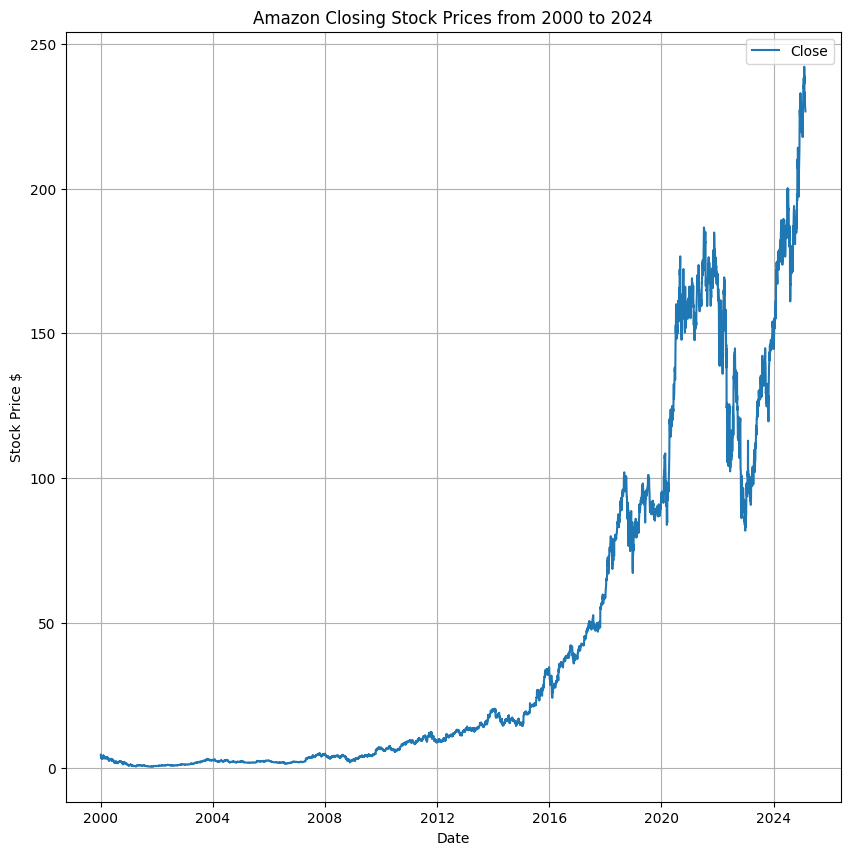

In [17]:
# Plotting the open, close, high and low prices
plt.figure(figsize=(10, 10))
plt.plot(df['date'], df["close"], label= "Close")
plt.title("Amazon Closing Stock Prices from 2000 to 2024")
plt.xlabel('Date')
plt.ylabel('Stock Price $')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Calculate daily return for the closing stock price
df['Daily Return_Close'] = df['close'].pct_change()

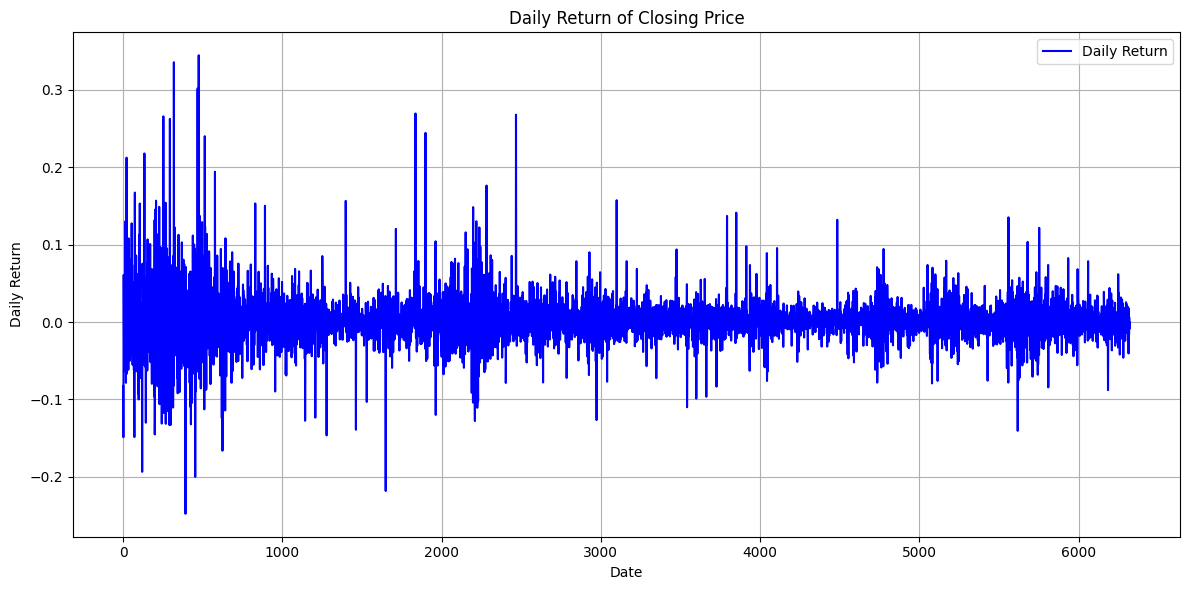

In [20]:
# Plot the daily return
plt.figure(figsize=(12, 6))
plt.plot(df['Daily Return_Close'], label='Daily Return', color='blue')
plt.title('Daily Return of Closing Price')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


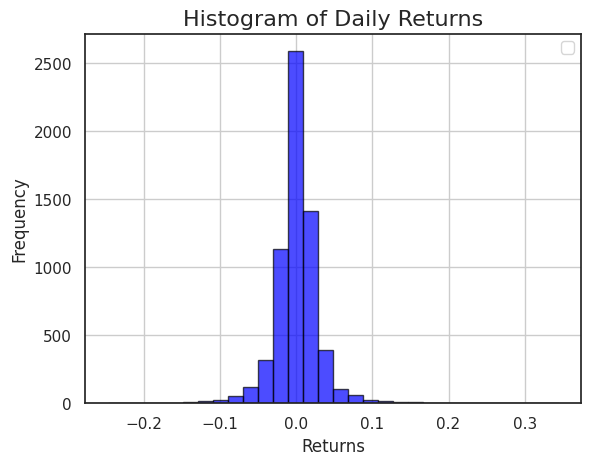

In [24]:
plt.hist(df["Daily Return_Close"], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Daily Returns", fontsize=16)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume',
       'Daily Return_Close'],
      dtype='object')

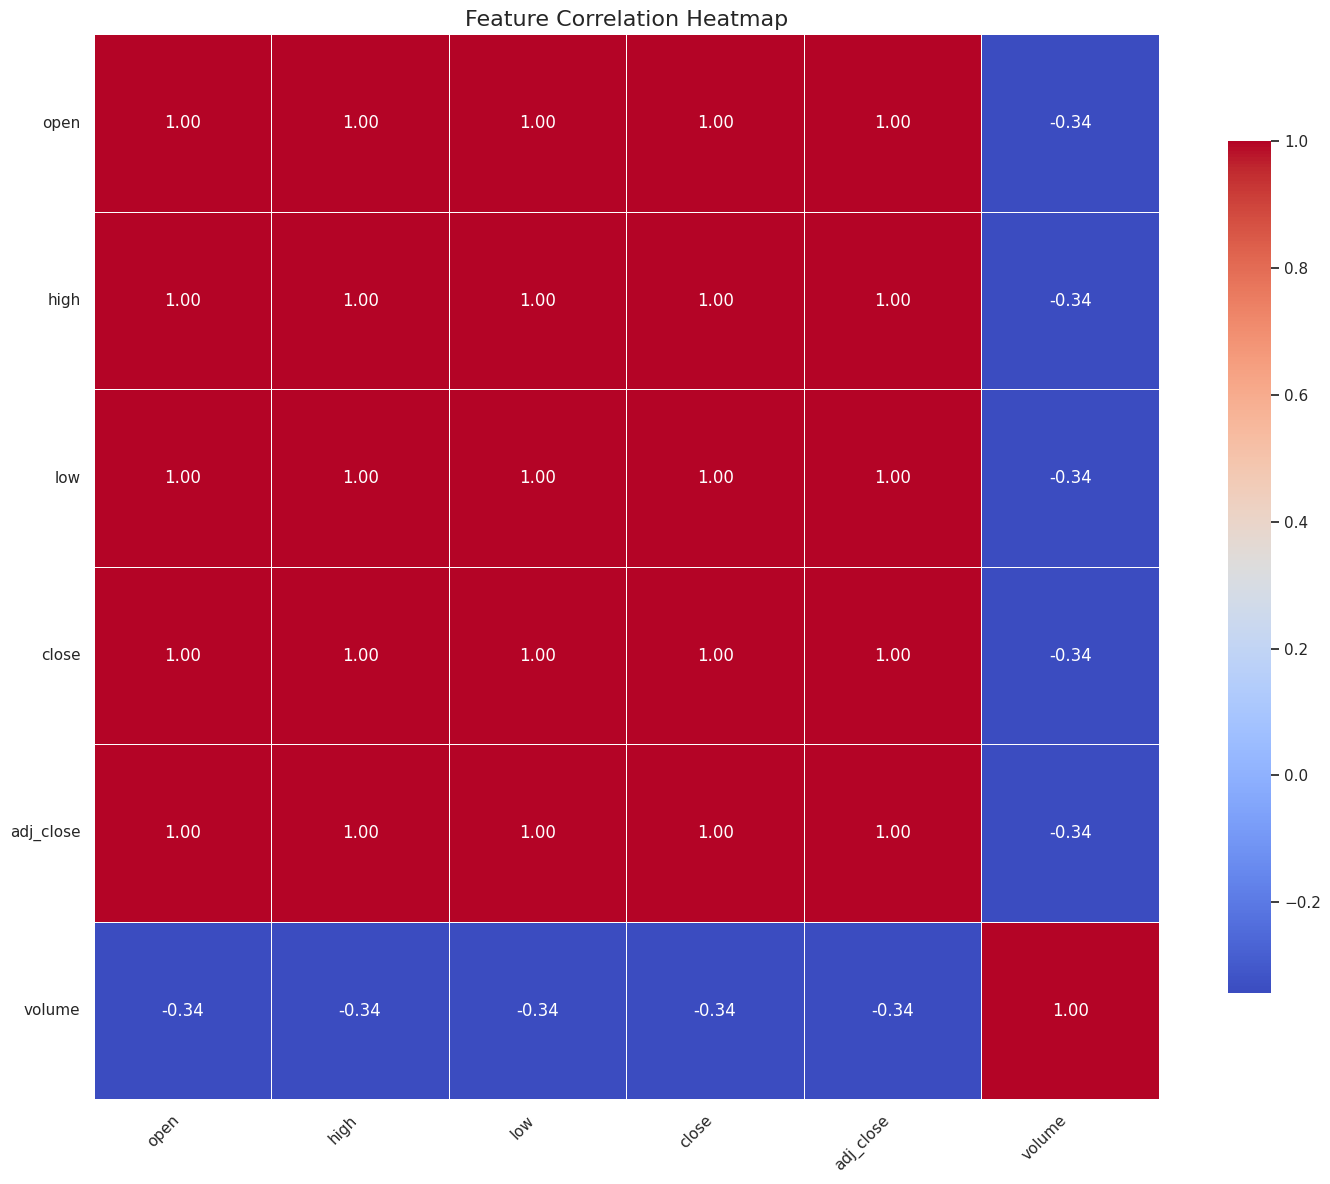

In [23]:
features = df[['open', 'high', 'low', 'close', 'adj_close', 'volume']]
#Correlation between the financial metrics
plt.figure(figsize=(15, 12))
sns.set(style='white')
# Create heatmap
heatmap = sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True,
                      linewidths=0.5, cbar_kws={'shrink': 0.8})
# Titles and formatting
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
#Scale the closing price using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
data = df["close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)
def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(look_back, len(data)):
                X.append(data[i - look_back:i, 0])  # Look-back period
                Y.append(data[i, 0])  # Target value
            return np.array(X), np.array(Y)
look_back= 60
X, y = create_dataset(scaled_data, look_back)

# Split into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)
X_train.shape, X_val.shape, X_test.shape

((4382, 60, 1, 1, 1), (939, 60, 1, 1, 1), (940, 60, 1, 1, 1))

In [26]:
# CNN-LSTM model with the specified architecture
cl = Sequential()
cl.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
cl.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
cl.add(TimeDistributed(Flatten()))
cl.add(Bidirectional(LSTM(100, return_sequences=True)))
cl.add(Dropout(0.5))
cl.add(Bidirectional(LSTM(100, return_sequences=False)))
cl.add(Dropout(0.5))
cl.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
cl.compile(optimizer=optimizer, loss='mean_squared_error')
cl.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 60, 1, 1, 64)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 60, 1, 1, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 60, 1, 1, 128)       │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 60, 1, 1, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 60, 1, 1, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 60, 1, 1, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 60, 200)             │         132,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,705 (1.49 MB)

 Trainable params: 389,705 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Fit the model
history = cl.fit(X_train,y_train,epochs=50,batch_size= 64,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - loss: 0.0315 - val_loss: 6.0975e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0020 - val_loss: 4.6573e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0016 - val_loss: 5.0197e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0015 - val_loss: 4.3666e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0014 - val_loss: 4.1984e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0013 - val_loss: 6.6064e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0014 - val_loss: 3.5204e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0013 - val_loss: 5.3494e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0012 - val_loss: 3.2146e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0012 - val_loss: 4.2270e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0012 - val_loss: 3.0753e-04
Epoch 12/50
69/69

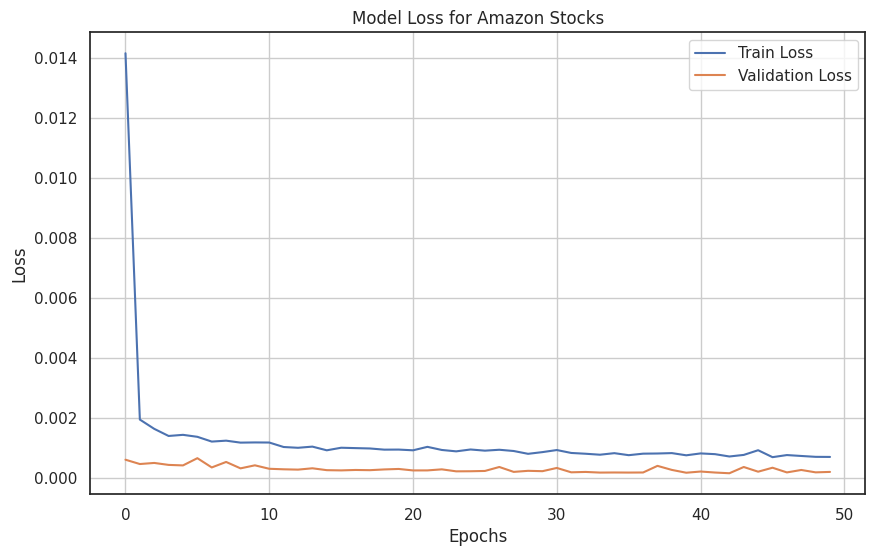

In [28]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


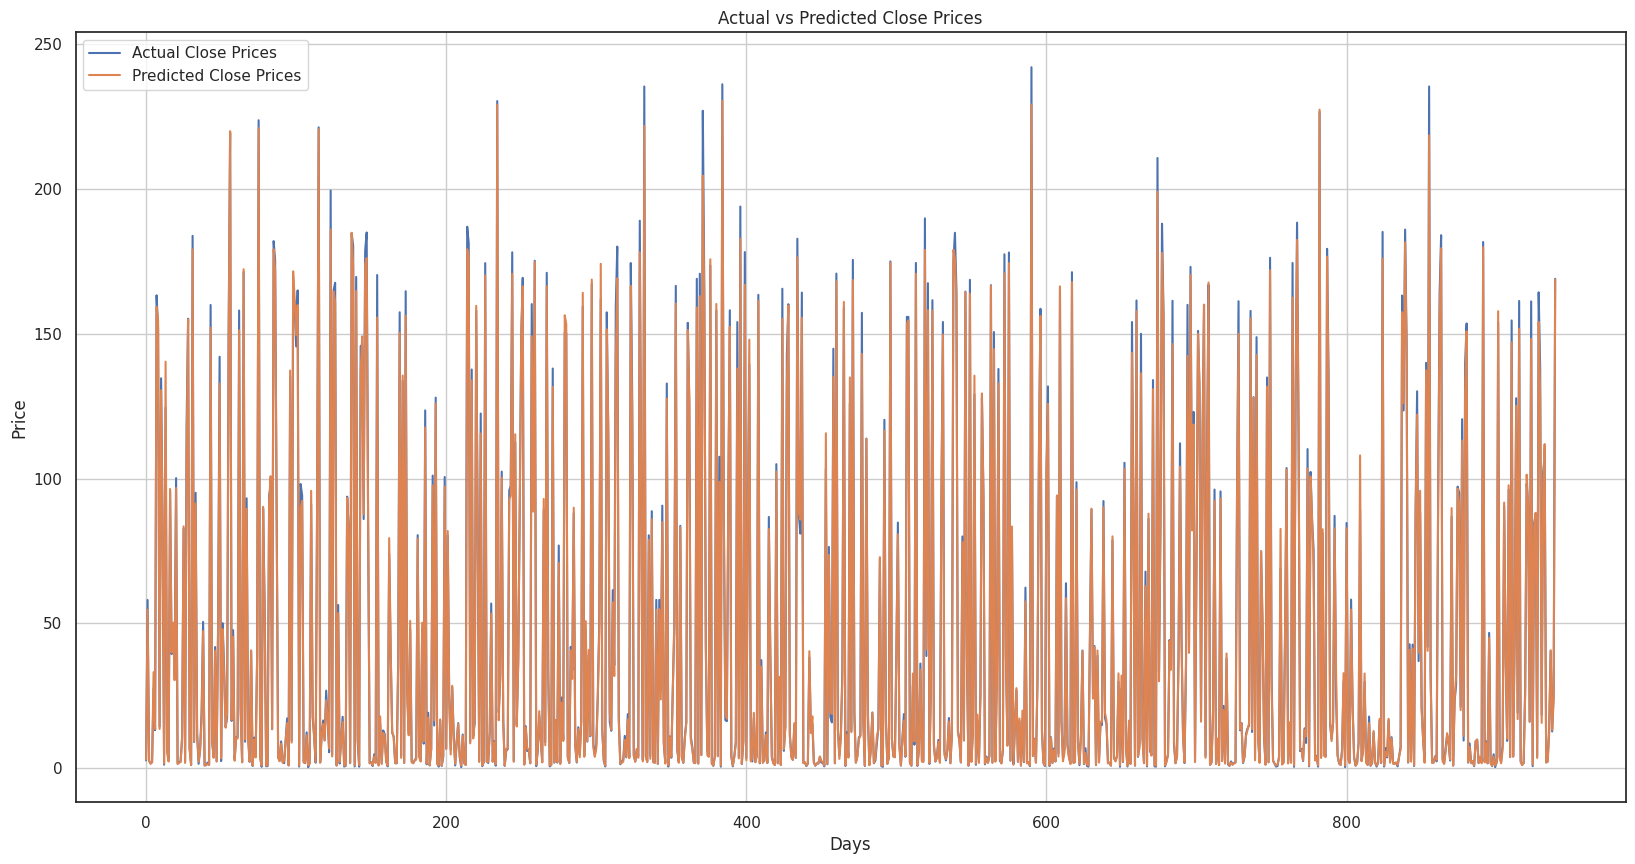

In [30]:
# Predictions
y_pred = cl.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 3.5618667828442403, MAE: 1.9196342836352103, R-squared: 0.9966642705897852


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


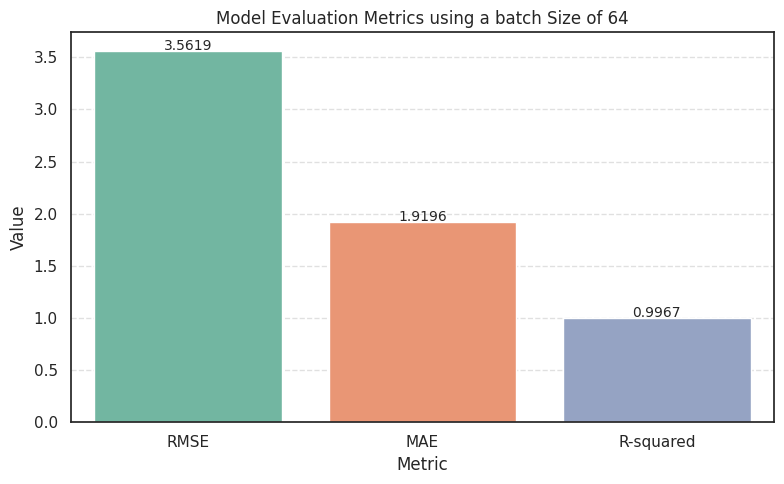

In [32]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 64')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

Using a Higher Batch-size of 128

In [33]:
# CNN-LSTM model with the specified architecture
m2 = Sequential()
m2.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m2.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m2.add(TimeDistributed(Flatten()))
m2.add(Bidirectional(LSTM(100, return_sequences=True)))
m2.add(Dropout(0.5))
m2.add(Bidirectional(LSTM(100, return_sequences=False)))
m2.add(Dropout(0.5))
m2.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m2.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# Fit the model
history = m2.fit(X_train,y_train,epochs=50,batch_size= 128,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - loss: 0.0653 - val_loss: 0.0087
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0056 - val_loss: 5.9450e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0020 - val_loss: 4.5287e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0019 - val_loss: 4.5493e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0015 - val_loss: 3.6342e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014 - val_loss: 3.7847e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0014 - val_loss: 3.1739e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0012 - val_loss: 3.0903e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014 - val_loss: 3.1200e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014 - val_loss: 3.0552e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0012 - val_loss: 2.9236e-04
Epoch 12/50
35/35 ━━━

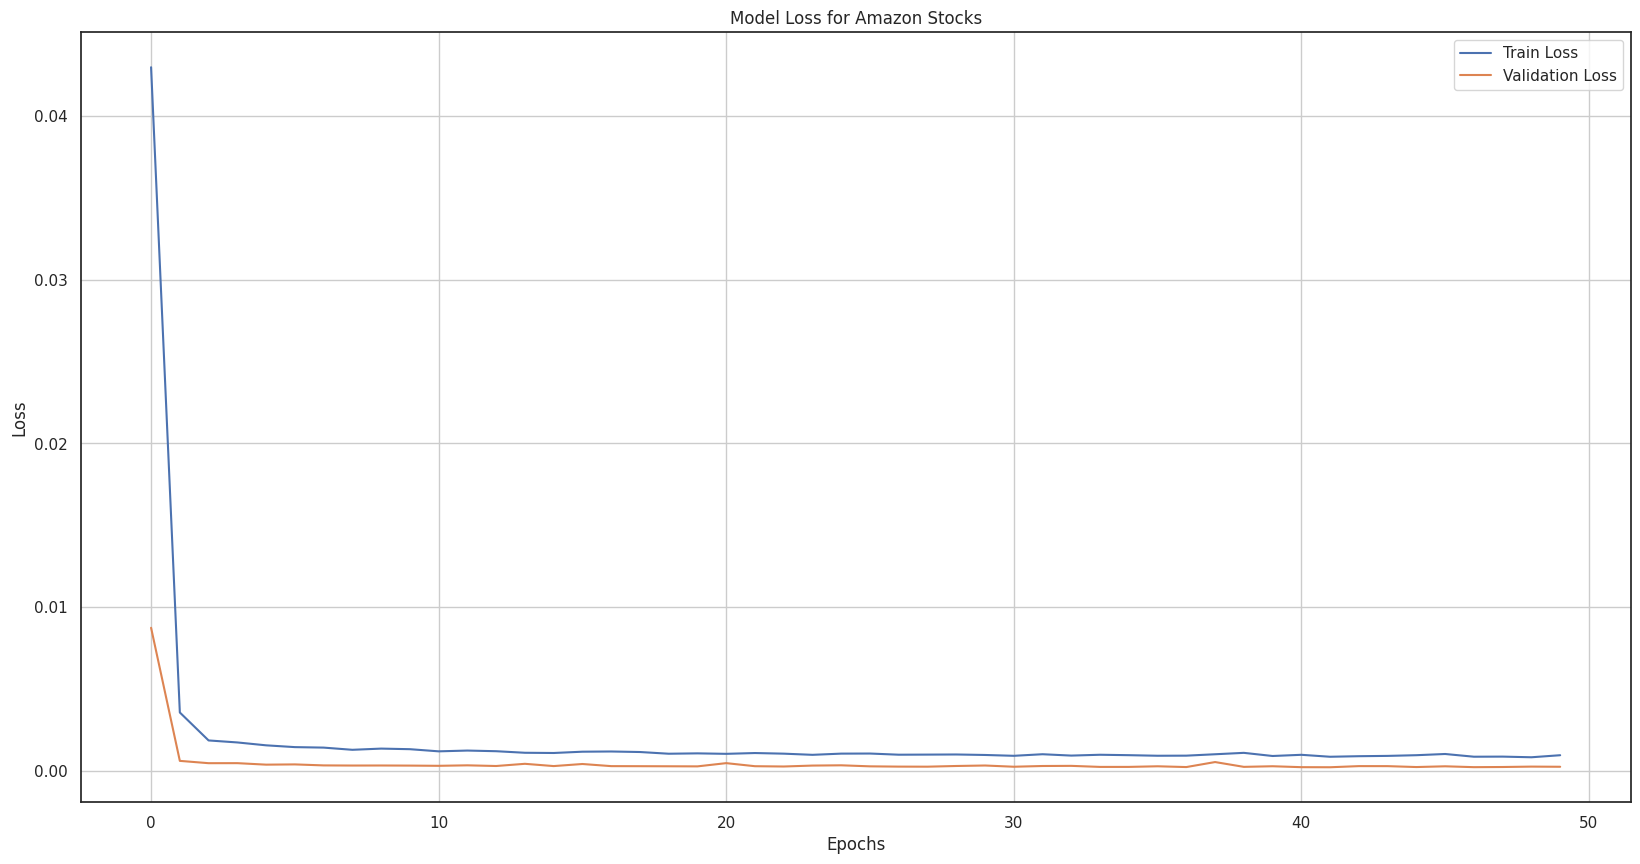

In [35]:
# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step


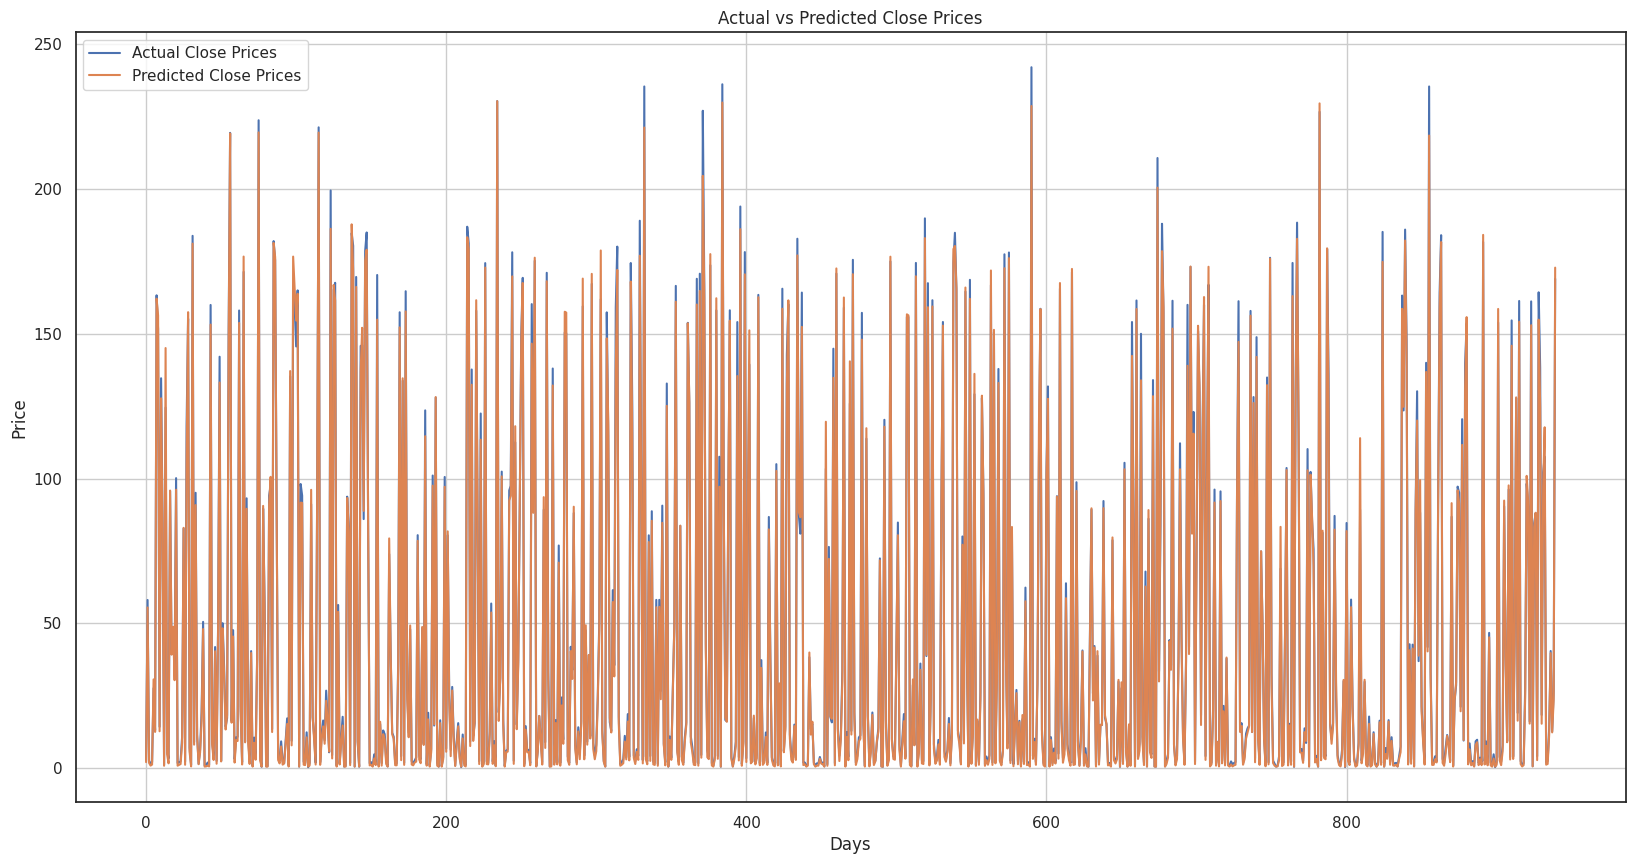

In [36]:
# Predictions
y_pred = m2.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 3.8434459640102467, MAE: 2.2131594473694234, R-squared: 0.9961160196111497


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


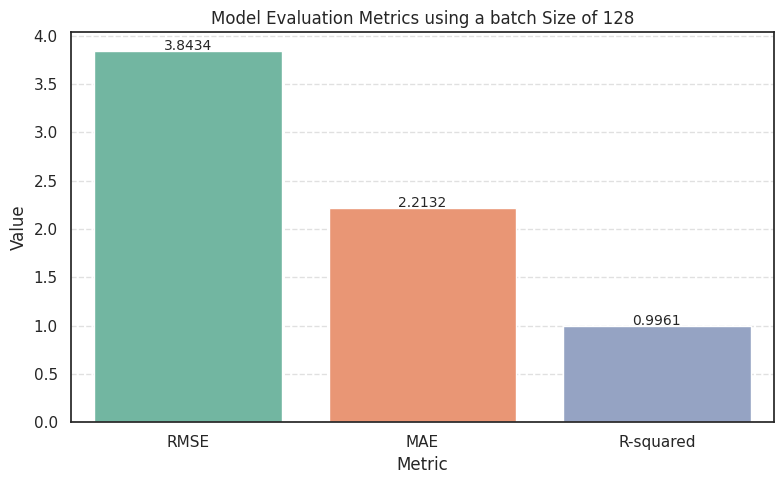

In [39]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 128')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

Using a batch-size of 256

In [40]:
# CNN-LSTM model with the specified architecture
m3 = Sequential()
m3.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m3.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m3.add(TimeDistributed(Flatten()))
m3.add(Bidirectional(LSTM(100, return_sequences=True)))
m3.add(Dropout(0.5))
m3.add(Bidirectional(LSTM(100, return_sequences=False)))
m3.add(Dropout(0.5))
m3.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m3.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Fit the model
history = m3.fit(X_train,y_train,epochs=50,batch_size= 256,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - loss: 0.0675 - val_loss: 0.0196
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0127 - val_loss: 0.0040
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0042 - val_loss: 5.8977e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0021 - val_loss: 6.5590e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0019 - val_loss: 5.1380e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0018 - val_loss: 4.8183e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0018 - val_loss: 4.6120e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0016 - val_loss: 4.7005e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0016 - val_loss: 4.4357e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0015 - val_loss: 4.3538e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0016 - val_loss: 4.1898e-04
Epoch 12/50
18/18 ━━━━━━━

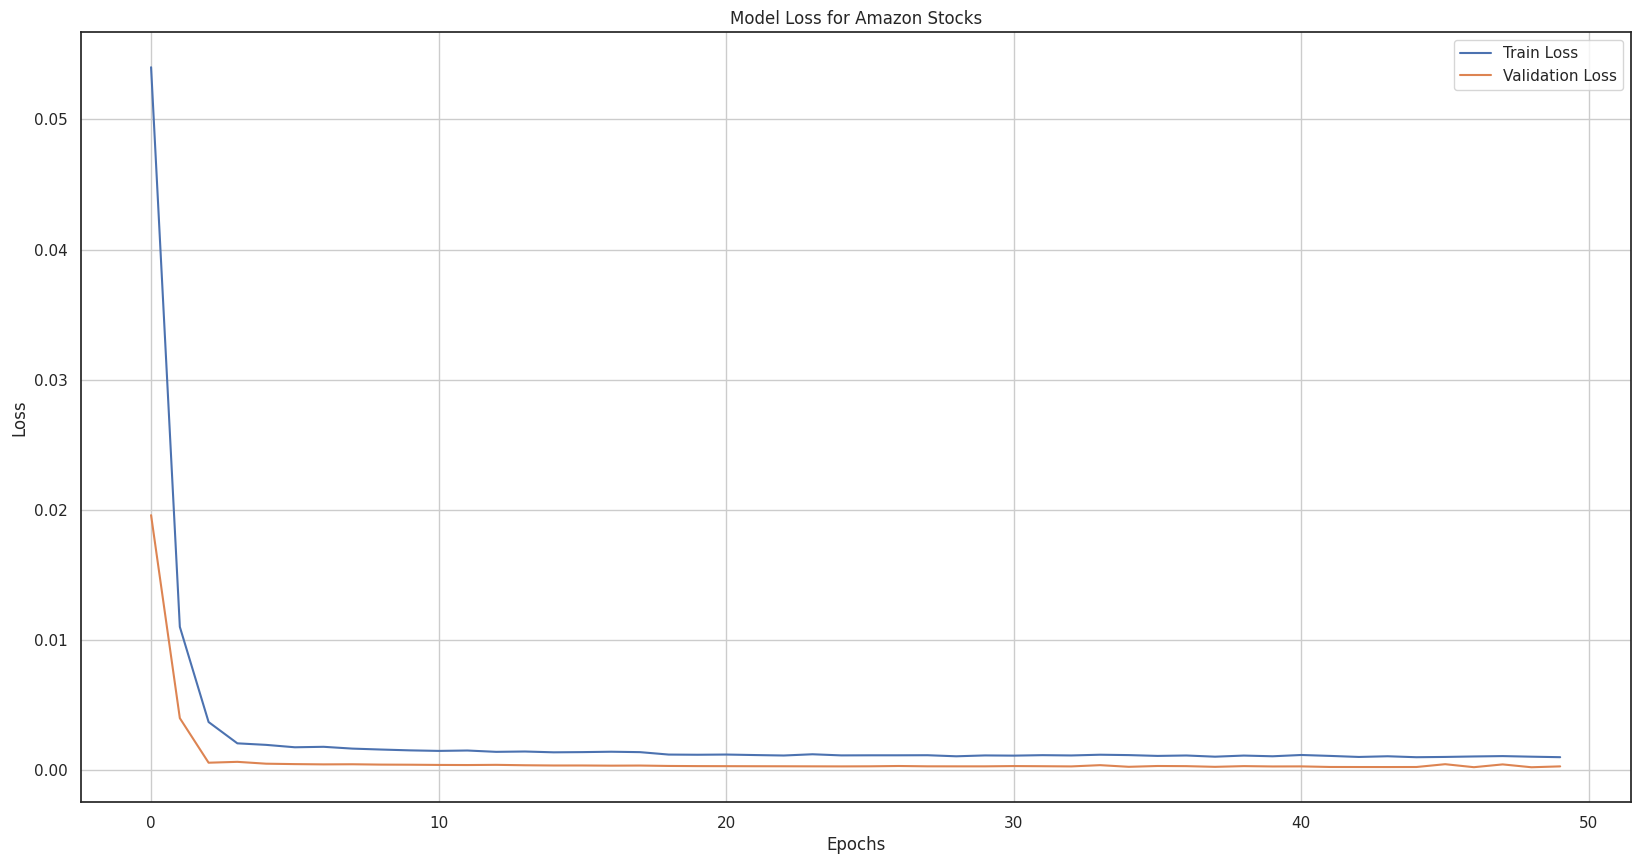

In [42]:
# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step


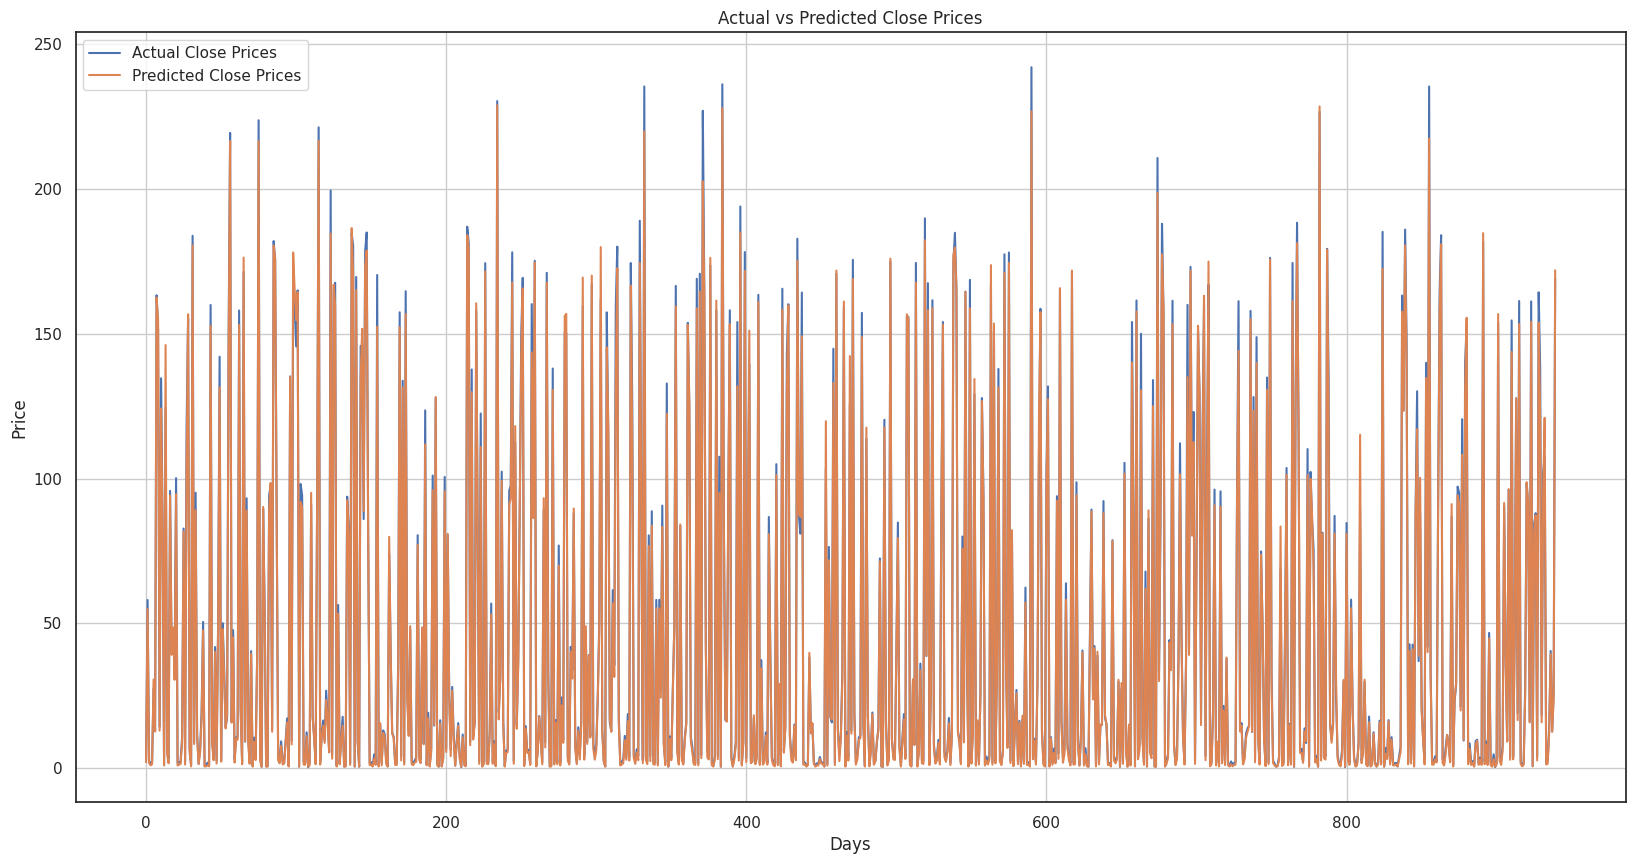

In [43]:
# Predictions
y_pred = m3.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 4.396785692096501, MAE: 2.423570759023758, R-squared: 0.9949171643799766


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


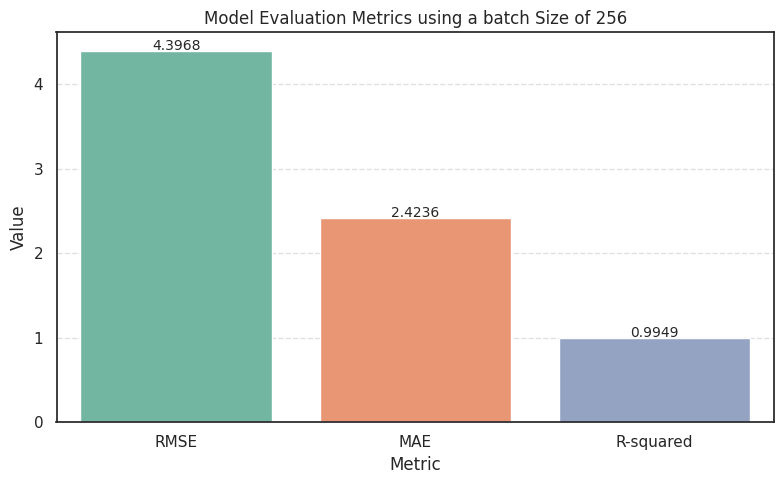

In [46]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a batch Size of 256')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

Observation: The model's predictive performance in terms of the R-squared metric showed that accuracy decreases with an increase in batch size, ranging from 64 to 256.

**USING DIFFERENT TIME LAGS TO ANALYZE THE EFFECT**

Considering 50, 80, and 100 previous time steps to predict the 51st, 81st, and 101st closing prices.

In [47]:
#Scale the closing price using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
data = df["close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)
def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(look_back, len(data)):
                X.append(data[i - look_back:i, 0])  # Look-back period
                Y.append(data[i, 0])  # Target value
            return np.array(X), np.array(Y)
look_back= 50
X, y = create_dataset(scaled_data, look_back)

# Split into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)
X_train.shape, X_val.shape, X_test.shape

((4389, 50, 1, 1, 1), (941, 50, 1, 1, 1), (941, 50, 1, 1, 1))

In [48]:
# CNN-LSTM model with the specified architecture
m4 = Sequential()
m4.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m4.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m4.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m4.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m4.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m4.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m4.add(TimeDistributed(Flatten()))
m4.add(Bidirectional(LSTM(100, return_sequences=True)))
m4.add(Dropout(0.5))
m4.add(Bidirectional(LSTM(100, return_sequences=False)))
m4.add(Dropout(0.5))
m4.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m4.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Fit the model
history = m4.fit(X_train,y_train,epochs=50,batch_size= 64,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0458 - val_loss: 5.8448e-04
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0023 - val_loss: 5.7990e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0016 - val_loss: 4.3709e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0015 - val_loss: 5.3050e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0014 - val_loss: 4.0445e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0014 - val_loss: 3.7047e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0013 - val_loss: 3.7514e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0014 - val_loss: 3.4021e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0013 - val_loss: 3.4902e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0012 - val_loss: 3.2248e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0011 - val_loss: 3.2282e-04
Epoch 12/50
69/69 

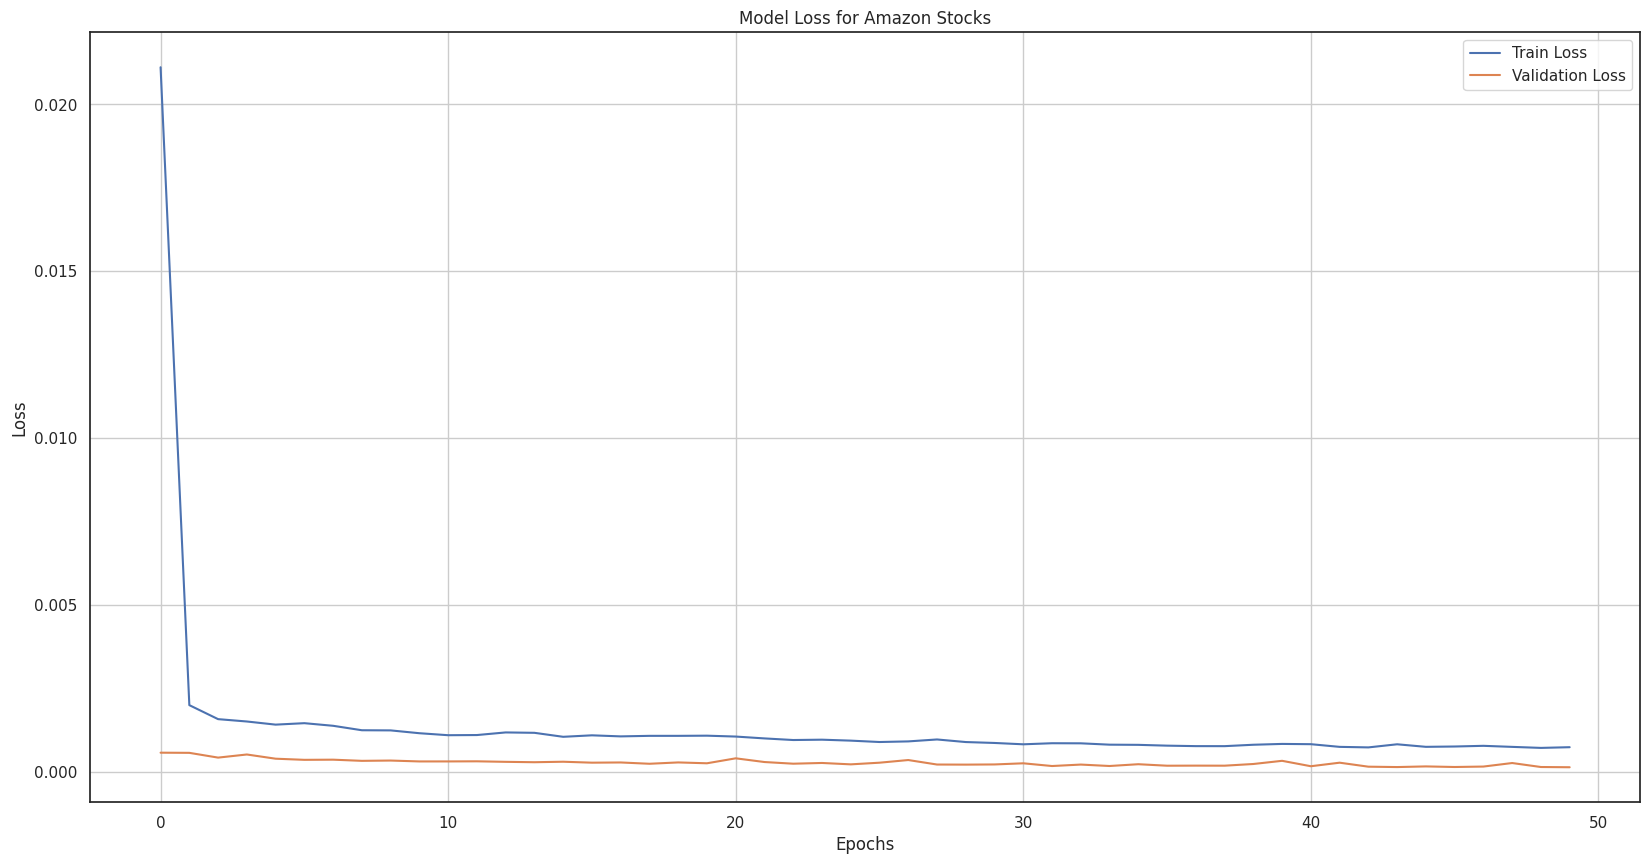

In [50]:
# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step


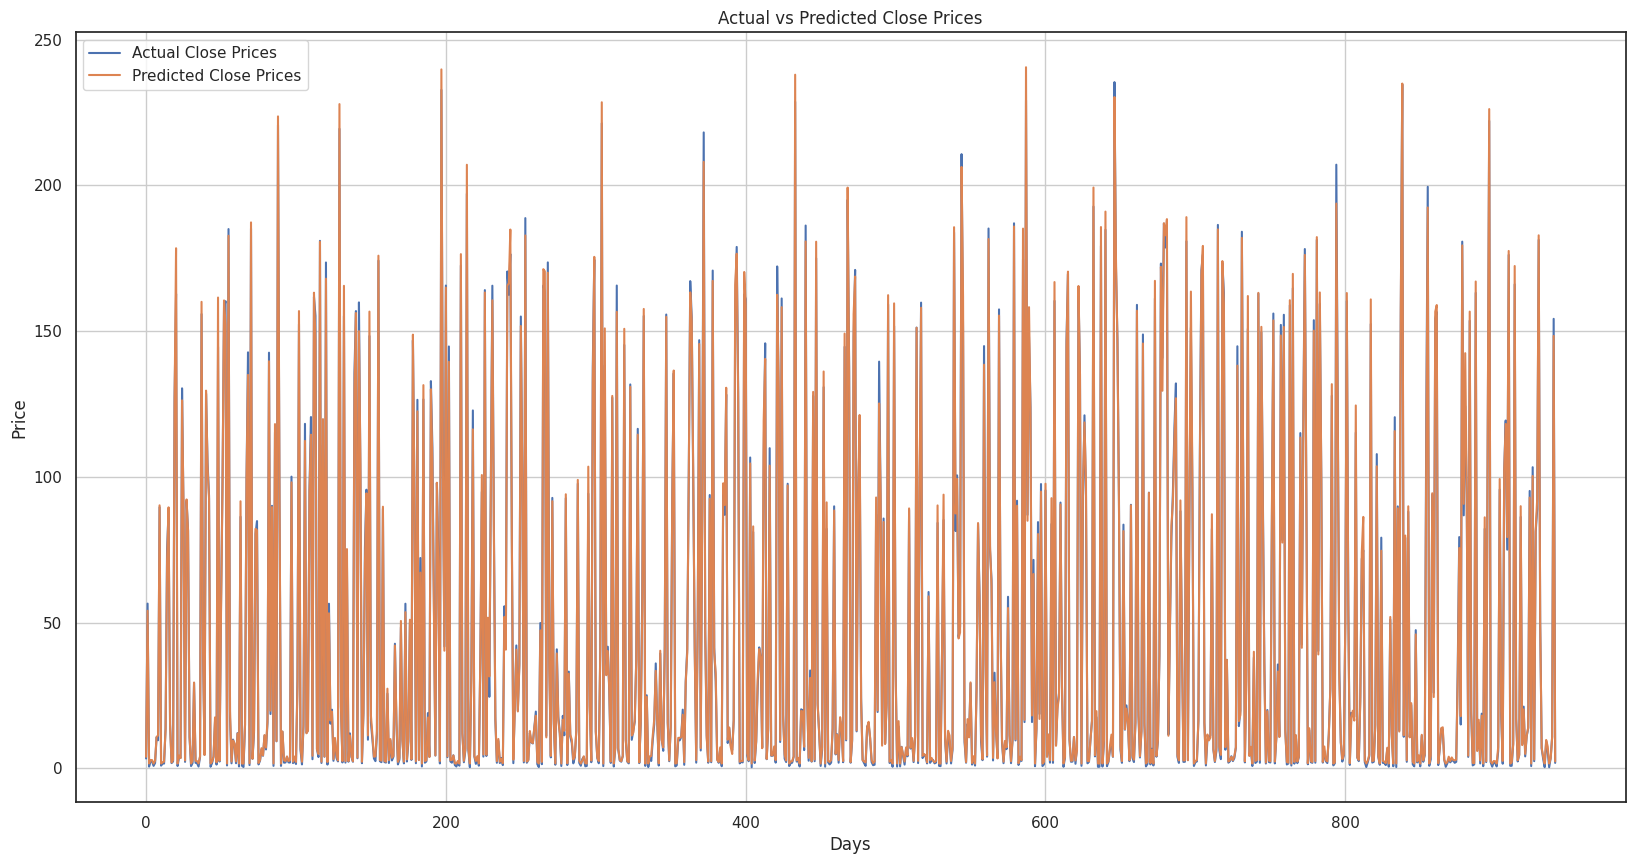

In [51]:
# Predictions
y_pred = m4.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 2.9761726903665595, MAE: 1.7518174999198546, R-squared: 0.9976270972589933


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


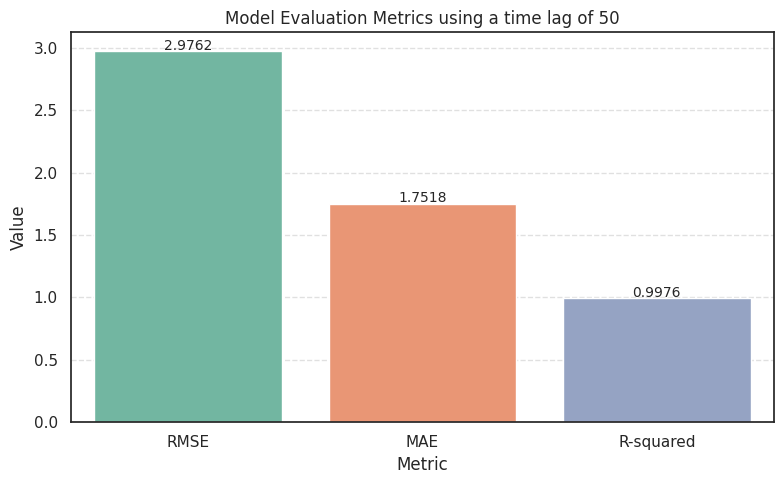

In [57]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a time lag of 50')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

80

In [54]:
#Scale the closing price using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
data = df["close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)
def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(look_back, len(data)):
                X.append(data[i - look_back:i, 0])  # Look-back period
                Y.append(data[i, 0])  # Target value
            return np.array(X), np.array(Y)
look_back= 80
X, y = create_dataset(scaled_data, look_back)

# Split into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)
X_train.shape, X_val.shape, X_test.shape

((4368, 80, 1, 1, 1), (936, 80, 1, 1, 1), (937, 80, 1, 1, 1))

In [55]:
# CNN-LSTM model with the specified architecture
m5 = Sequential()
m5.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m5.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m5.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m5.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m5.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m5.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m5.add(TimeDistributed(Flatten()))
m5.add(Bidirectional(LSTM(100, return_sequences=True)))
m5.add(Dropout(0.5))
m5.add(Bidirectional(LSTM(100, return_sequences=False)))
m5.add(Dropout(0.5))
m5.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m5.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
# Fit the model
history = m5.fit(X_train,y_train,epochs=50,batch_size= 64,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - loss: 0.0405 - val_loss: 0.0011
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0021 - val_loss: 8.9874e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0020 - val_loss: 6.8276e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0018 - val_loss: 5.5256e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0015 - val_loss: 5.3416e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0016 - val_loss: 5.0885e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0015 - val_loss: 5.0509e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0013 - val_loss: 4.4138e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0013 - val_loss: 4.0475e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0013 - val_loss: 3.8352e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0014 - val_loss: 3.7229e-04
Epoch 12/50
69/69 ━━━

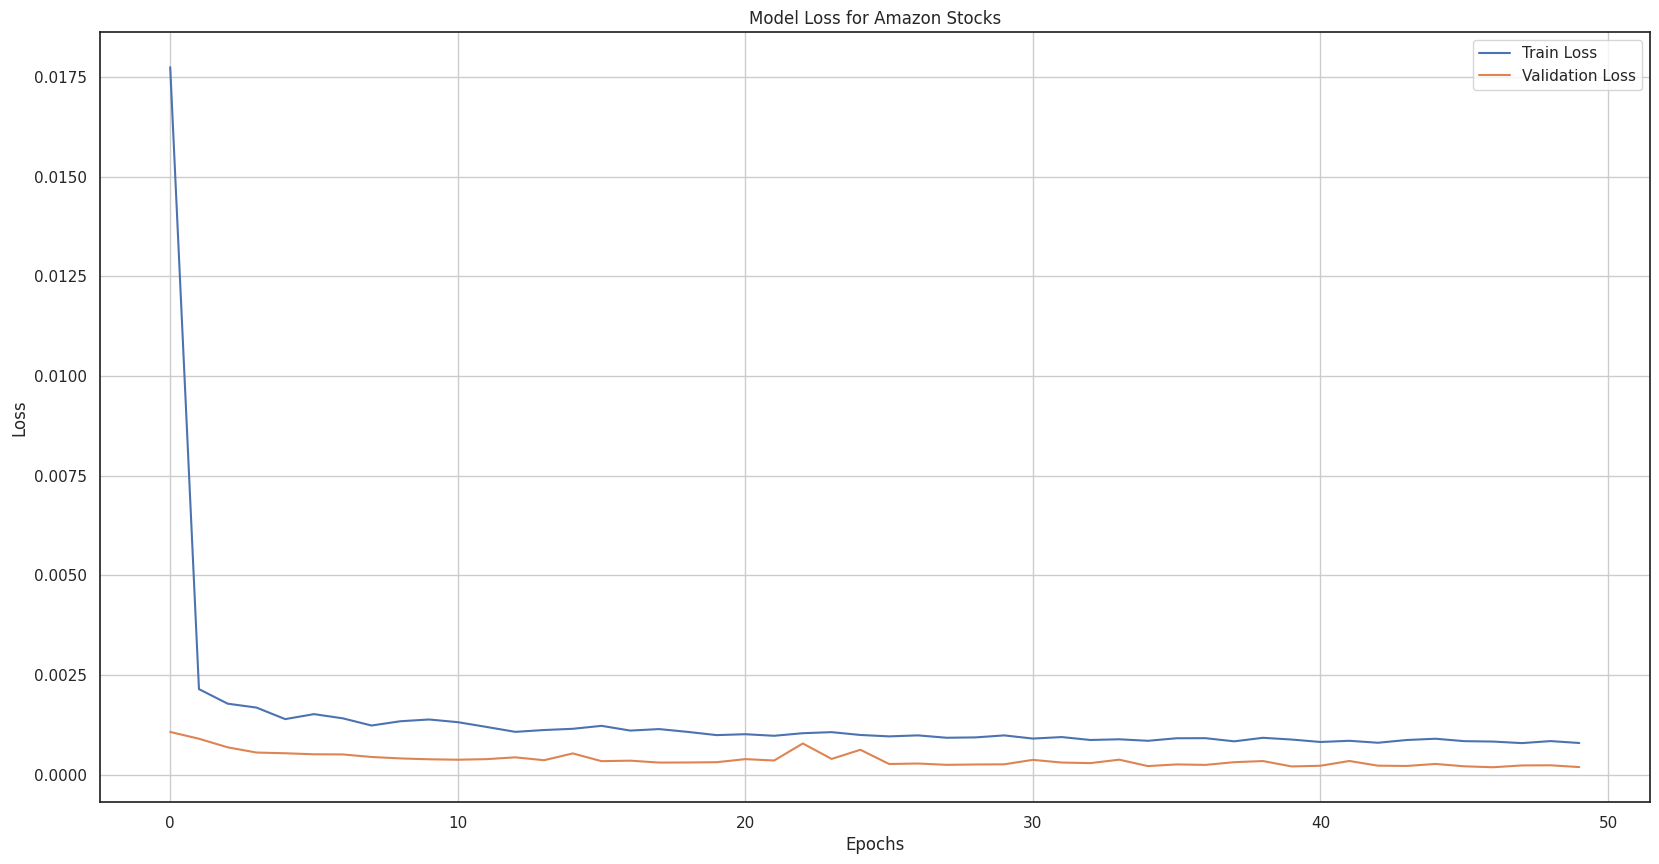

In [58]:
# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step


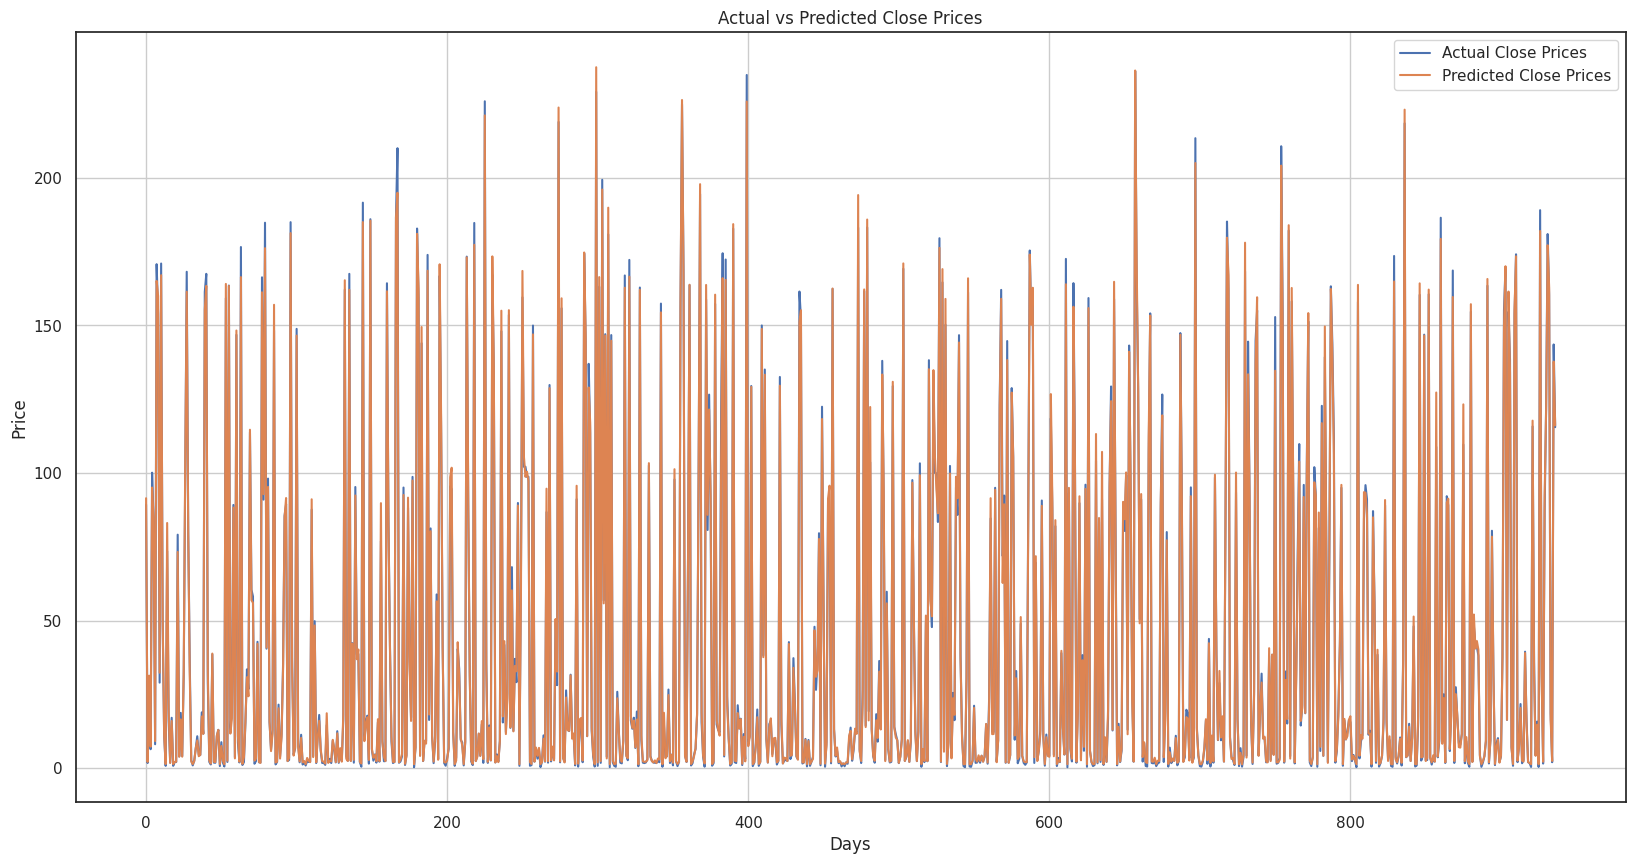

In [59]:
# Predictions
y_pred = m5.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 3.0093925906474825, MAE: 1.7607016660106094, R-squared: 0.9973988280139675


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


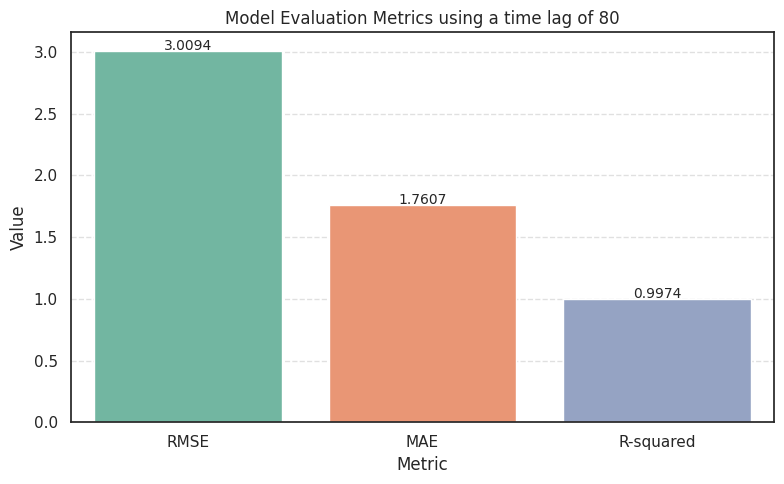

In [65]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a time lag of 80')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

100

In [66]:
#Scale the closing price using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
data = df["close"].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)
def create_dataset(data, look_back):
            X, Y = [], []
            for i in range(look_back, len(data)):
                X.append(data[i - look_back:i, 0])  # Look-back period
                Y.append(data[i, 0])  # Target value
            return np.array(X), np.array(Y)
look_back= 100
X, y = create_dataset(scaled_data, look_back)

# Split into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], look_back, 1, 1, 1)
X_val = X_val.reshape(X_val.shape[0], look_back, 1, 1, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1, 1, 1)
X_train.shape, X_val.shape, X_test.shape

((4354, 100, 1, 1, 1), (933, 100, 1, 1, 1), (934, 100, 1, 1, 1))

In [67]:
# CNN-LSTM model with the specified architecture
m6 = Sequential()
m6.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
                               input_shape=(look_back, 1, 1, 1)))
m6.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m6.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1, 1), activation='relu')))
m6.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m6.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1, 1), activation='relu')))
m6.add(TimeDistributed(MaxPooling2D(pool_size=(1, 1))))
m6.add(TimeDistributed(Flatten()))
m6.add(Bidirectional(LSTM(100, return_sequences=True)))
m6.add(Dropout(0.5))
m6.add(Bidirectional(LSTM(100, return_sequences=False)))
m6.add(Dropout(0.5))
m6.add(Dense(1))
# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
m6.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
# Fit the model
history = m6.fit(X_train,y_train,epochs=50,batch_size= 64,validation_data=(X_val, y_val),verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - loss: 0.0459 - val_loss: 0.0010
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0021 - val_loss: 9.3525e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0017 - val_loss: 7.4271e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0018 - val_loss: 5.6650e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0013 - val_loss: 5.4270e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0014 - val_loss: 5.6170e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0012 - val_loss: 4.7424e-04
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0014 - val_loss: 4.4189e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0014 - val_loss: 4.4636e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0012 - val_loss: 5.1409e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0013 - val_loss: 4.0159e-04
Epoch 12/50
69/69 ━━━

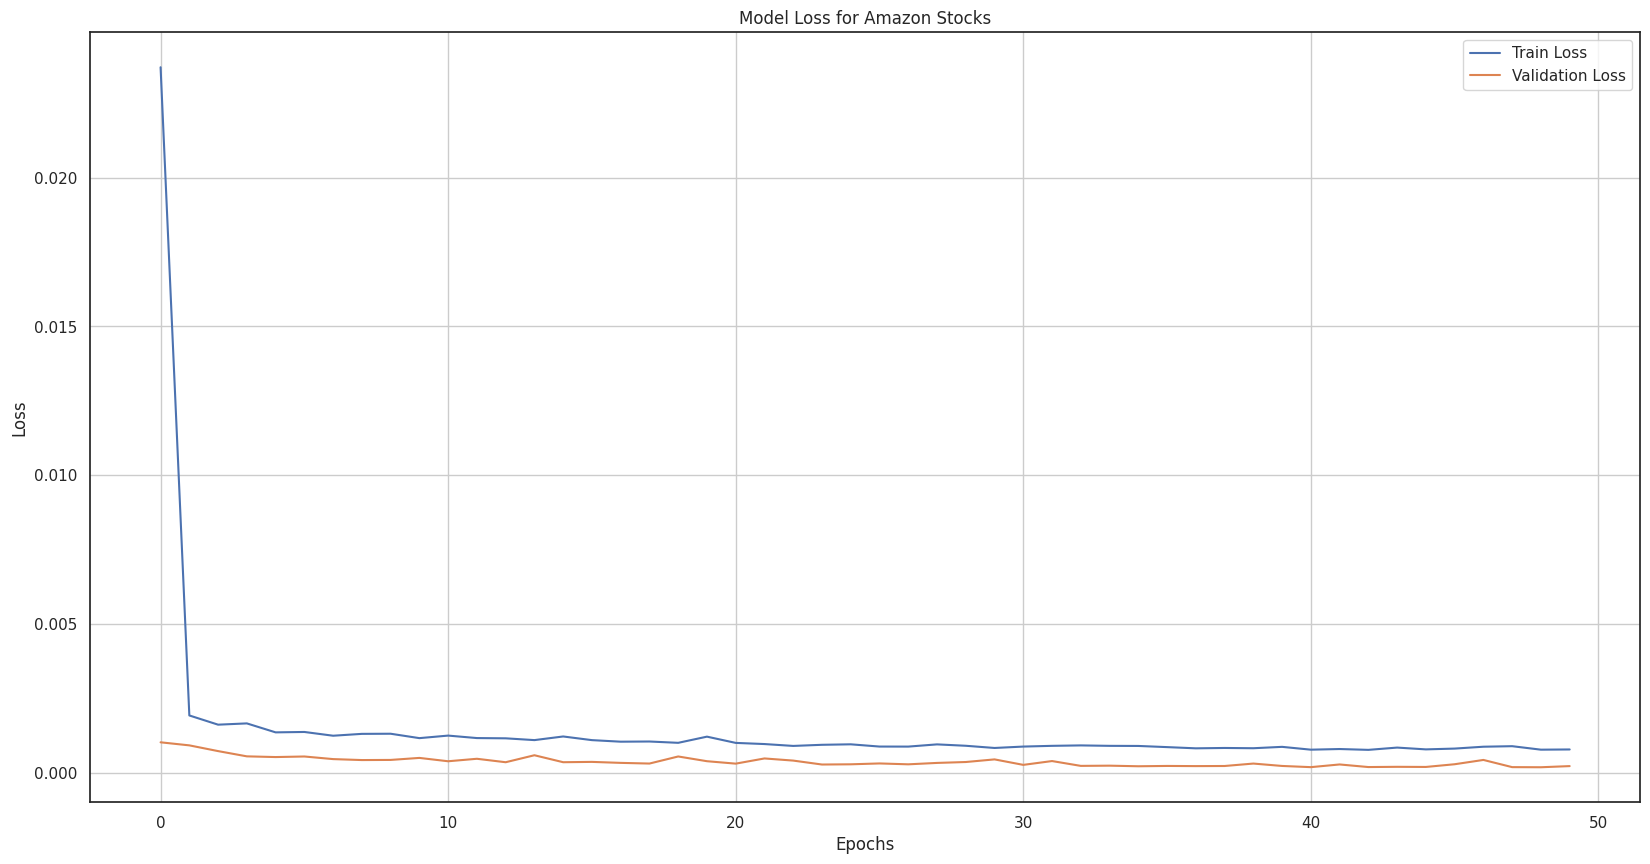

In [69]:
# Plot training & validation loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Amazon Stocks')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step


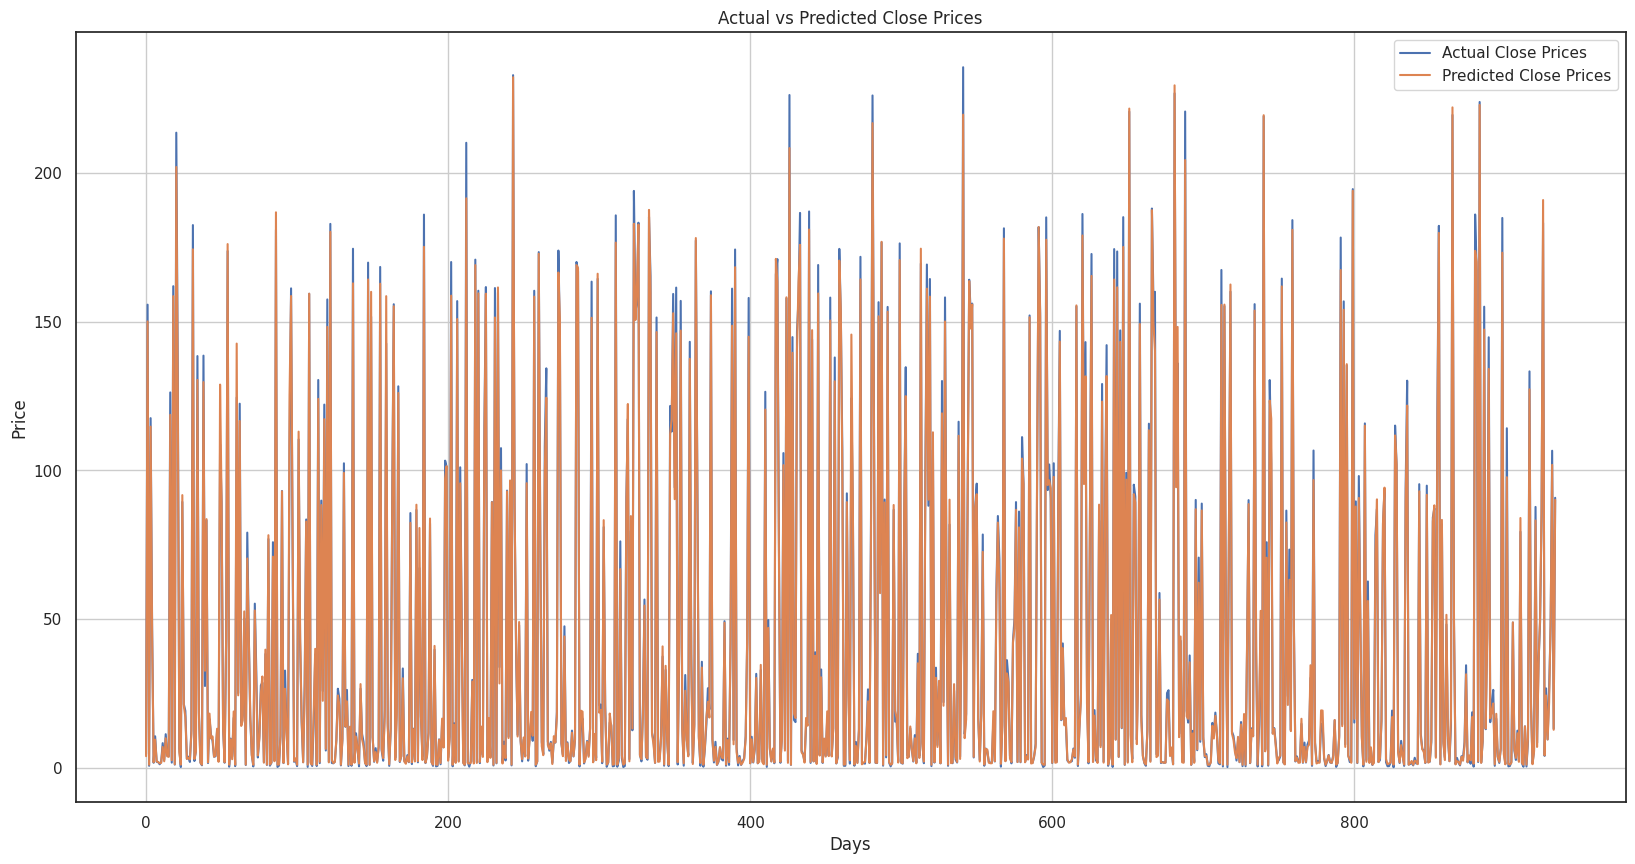

In [72]:
# Predictions
y_pred = m6.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the Price prediciton 
plt.figure(figsize=(20, 10))
plt.plot(y_test_inv, label='Actual Close Prices')
plt.plot(y_pred_inv, label='Predicted Close Prices')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
#Model metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r_squared = r2_score(y_test_inv, y_pred_inv)
print(f"Model - RMSE: {rmse}, MAE: {mae}, R-squared: {r_squared}")

Model - RMSE: 3.8224940740483135, MAE: 2.1252276101638214, R-squared: 0.9959261163992852


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


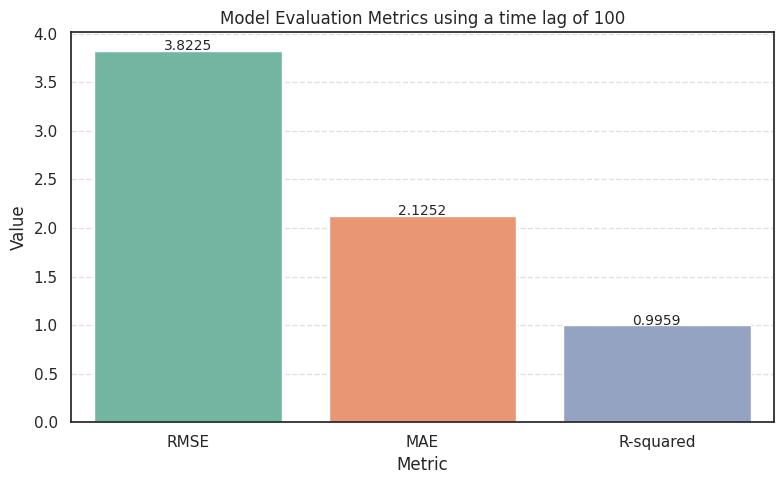

In [74]:
# List format metrics
metrics = ['RMSE', 'MAE', 'R-squared']
values = [rmse, mae, r_squared]  # Replace with your actual values
# Plotting the performance metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='Set2')
plt.title('Model Evaluation Metrics using a time lag of 100')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Annotate values on top of bars
for i, val in enumerate(values):
    plt.text(i, val + 0.01, f'{val:.4f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

**Observation:** The predictive accuracy in terms of the R-squared metric showed a decrease in variance capture as the time lag increased from 50 to 100, with a maximum R-squared value of 99.76.